# Classification Between WNT and SHH 

## Required Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

## Data Preprocessing/Loading

In [2]:
# load data
file_path = "/Users/samwwong/Desktop/Michael Zhang/wnt_shh.xlsx"
df = pd.read_excel(file_path)
df.head()

,molecular,molec_id,sex,dx_date,age,alive,os,pfs,seg_id,t1_log-sigma-1-mm-3D_firstorder_10Percentile,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,shh,BO_PF-MB_F_0007,F,2000-05-05 00:00:00,79.0,NaN,33.0,NaN,BO_PF-MB_F_0007_,-14.446979,...,1.973686,0.000808,1027.170040,0.297042,0.562429,1220.949377,0.000601,7.518529,0.134000,5335.217376
1,wnt,BO_PF-MB_F_0008,F,2006-01-05 00:00:00,90.0,Alive,30.0,NaN,BO_PF-MB_F_0008_,-11.965873,...,0.243711,0.005756,344.000989,0.340258,0.604408,481.129194,0.004316,7.318544,0.252624,209.948818
2,wnt,BO_PF-MB_F_0010,F,2000-08-16 00:00:00,76.0,Alive,92.0,NaN,BO_PF-MB_F_0010_,-15.311574,...,0.049205,0.000786,4051.276393,0.385322,0.644380,1826.940136,0.000552,8.163314,0.350257,66.167310
3,shh,BO_PF-MB_F_0017,F,2004-06-06 00:00:00,27.0,Alive,44.0,NaN,BO_PF-MB_F_0017_,-25.161749,...,0.094180,0.001028,1305.932045,0.382523,0.642779,1897.521463,0.000611,7.748172,0.291049,174.711614
4,wnt,BO_PF-MB_F_0018,F,2001-06-28 00:00:00,79.0,Alive,79.0,NaN,BO_PF-MB_F_0018_,-26.974179,...,0.005837,0.000673,7426.264422,0.457198,0.703001,3377.254498,0.000484,8.368237,0.524441,5.161170


In [3]:
# obtain list of features selected from LASSO
reduced_feats_path = "/Users/samwwong/Desktop/Michael Zhang/reduced_molec.xlsx"
reduced_features = pd.read_excel(reduced_feats_path)
reduced_features_list = reduced_features.loc[reduced_features['wnt_shh'].isnull() == False, 
                                             ['wnt_shh']].values.tolist()
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]
features_after_lasso = df[reduced_features_list]
print(reduced_features_list)

['t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniformityNormalized', 't1_wavelet-LHL_glcm_Correlation', 't1_wavelet-LHL_glcm_Idn', 't2_wavelet-HHL_firstorder_InterquartileRange', 't2_wavelet-LLL_firstorder_Kurtosis', 't2_log-sigma-1-mm-3D_glszm_HighGrayLevelZoneEmphasis', 'age']


In [4]:
# Binarizing target
target = df["molecular"]

# Marking 0 as wnt and 1 shh
mapping_dict = {0: 'wnt', 1: 'shh'}
target = target.map(dict(wnt = 0, shh = 1))
print(target.value_counts())

1    83
0    26
Name: molecular, dtype: int64


In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)
print("TRAIN")
print(y_train.value_counts())

print("TEST")
print(y_test.value_counts())

TRAIN
1    60
0    21
Name: molecular, dtype: int64
TEST
1    23
0     5
Name: molecular, dtype: int64


### Resampling to Correct for Imbalance

In [6]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['molecular'] == 0]
X_1 = X[X['molecular'] == 1]

In [7]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [8]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]
print(y_train.value_counts())

1    60
0    60
Name: molecular, dtype: int64


### Standardizing Features

In [9]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [10]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [11]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

## Modeling

### User Defined Functions for Metrics

In [12]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.4f} - {:0.4}]".format(name, 
    confidence_lower, confidence_upper))

In [13]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TN / (TN + FP)

In [14]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [15]:
def negative_pv_score(y_true, y_pred):
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN)        

In [16]:
def print_metrics(y_test, y_pred):
    print("Sens Score: " + str.format('{0:.4f}', (recall_score(y_test, y_pred))))
    print("Spec Score: " + str.format('{0:.4f}', (specificity_score(y_test.to_numpy(), y_pred))))
    print("PPV Score: " + str.format('{0:.4f}', (positive_pv_score(y_test.to_numpy(), y_pred))))
    print("NPV Score: " + str.format('{0:.4f}', (negative_pv_score(y_test.to_numpy(), y_pred))))
    print("Acc Score: " + str.format('{0:.4f}', (accuracy_score(y_test, y_pred))))
    print("F1 Score: " + str.format('{0:.4f}', (f1_score(y_test, y_pred))))

In [17]:
def plot_roc_curve(model_name):
    sns.set()
    plt.figure(figsize=(7, 7))

    ns_preds = [0 for _ in range(len(y_test))]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name)
    plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

    plt.legend(loc='lower right')
    plt.title(f'{model_name}: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    short_auc = round(auc,4)
    plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
    plt.show()

In [18]:
def create_confusion_matrix(model_name, model, X, y):
    matrix = plot_confusion_matrix(model, X, y,
                               cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show(matrix)
    plt.show()

### User Defined Functions for Modeling

In [19]:
def grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

### SVM

#### Grid Search for Hyperparameters

In [20]:
svm_model = svm.SVC()
svm_grid_params = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

grid_search(svm_model, svm_grid_params, X_train, y_train)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


#### Model Performance

In [21]:
svm_model = svm.SVC(C = 1, gamma = 1, kernel = 'rbf', probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [22]:
print_metrics(y_test, y_pred)

Sens Score: 0.9565
Spec Score: 0.0000
PPV Score: 0.8148
NPV Score: 0.0000
Acc Score: 0.7857
F1 Score: 0.8800


In [23]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.9217


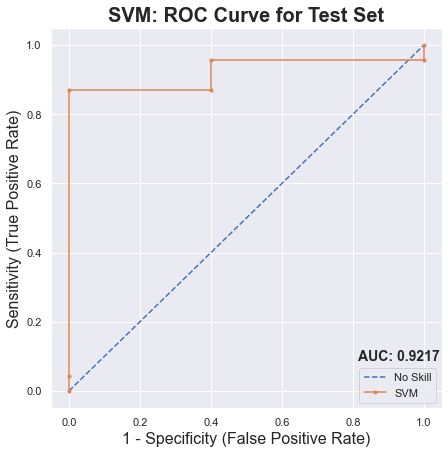

In [24]:
plot_roc_curve('SVM')

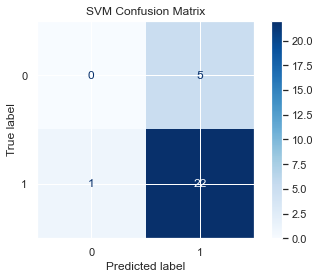

In [25]:
create_confusion_matrix('SVM', svm_model, X_test, y_test)

### Logistic Regression

#### Grid Search for Hyperparameters

In [26]:
lr_model = LogisticRegression()
lr_grid_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

grid_search(lr_model, lr_grid_params, X_train, y_train)

{'C': 0.01, 'penalty': 'l2'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.75              nan 0.75              nan 0.75833333
        nan 0.75              nan 0.75833333        nan 0.75
        nan 0.78333333        nan 0.75              nan 0.775
        nan 0.75      ]
  warnings.warn(


#### Model Performance

In [27]:
lr_model = LogisticRegression(penalty = 'none', C = 10)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [28]:
print_metrics(y_test, y_pred)

Sens Score: 0.7391
Spec Score: 1.0000
PPV Score: 1.0000
NPV Score: 0.4545
Acc Score: 0.7857
F1 Score: 0.8500


In [29]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.9652


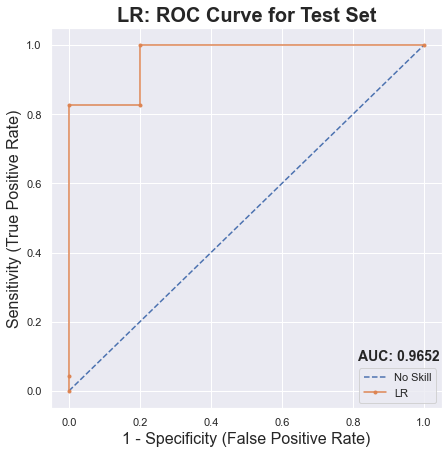

In [30]:
plot_roc_curve('LR')

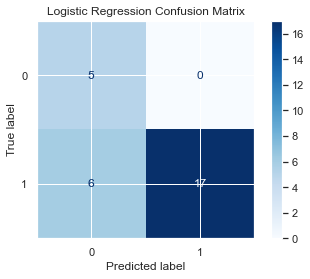

In [31]:
create_confusion_matrix('Logistic Regression', lr_model, X_test, y_test)

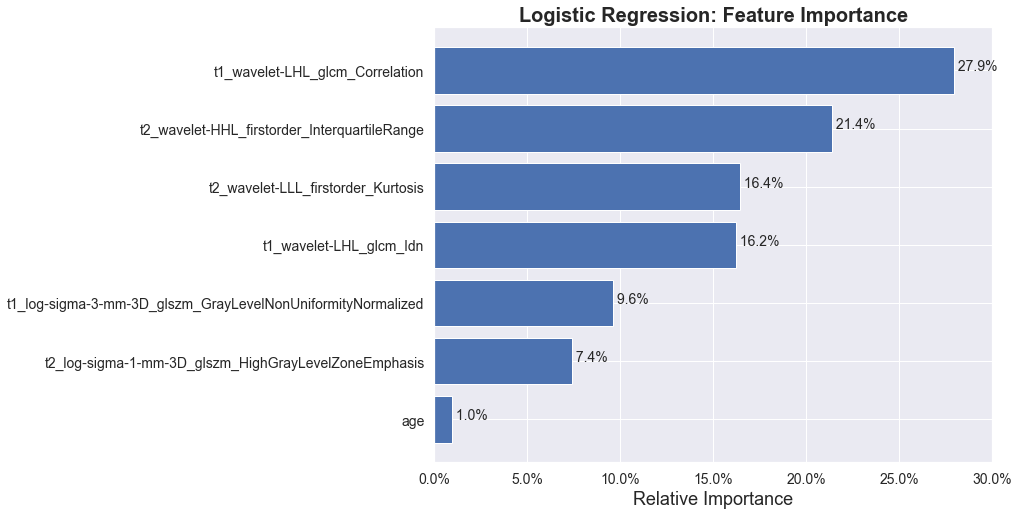

In [32]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.30)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14)

plt.xlabel('Relative Importance',fontsize=18)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(fontsize=14)

plt.show()

Feature: 0, Score: 0.00960
Feature: 1, Score: -0.07401
Feature: 2, Score: -0.09621
Feature: 3, Score: 0.16249
Feature: 4, Score: -0.16447
Feature: 5, Score: -0.21392
Feature: 6, Score: 0.27929


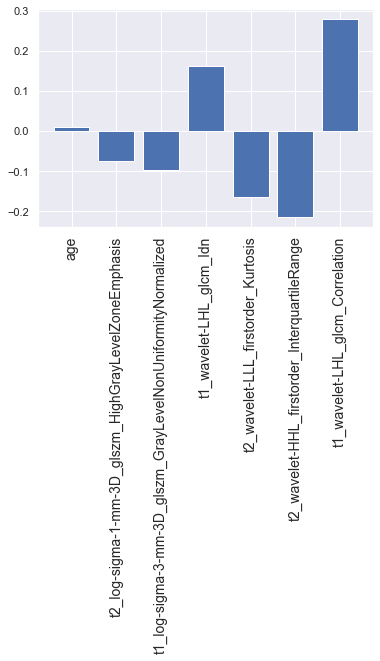

In [33]:
feature_names = X_test.columns.to_list()

importances_2 = lr_model.coef_[0]
importances_2 = (importances_2) / np.sum(np.abs(importances_2))

# summarize feature importance
for i,v in enumerate(importances_2[indices]):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importances_2))], importances_2[indices])
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14, rotation = 90)


plt.show()

### KNN

#### Grid Search for Hyperparameters

In [34]:
knn_model = KNeighborsClassifier()
knn_grid_params = {'n_neighbors': [3, 5, 7, 9]
}

grid_search(knn_model, knn_grid_params, X_train, y_train)

{'n_neighbors': 3}


#### Model Performance

In [35]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [36]:
print_metrics(y_test, y_pred)

Sens Score: 0.8696
Spec Score: 0.8000
PPV Score: 0.9524
NPV Score: 0.5714
Acc Score: 0.8571
F1 Score: 0.9091


In [37]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.9391


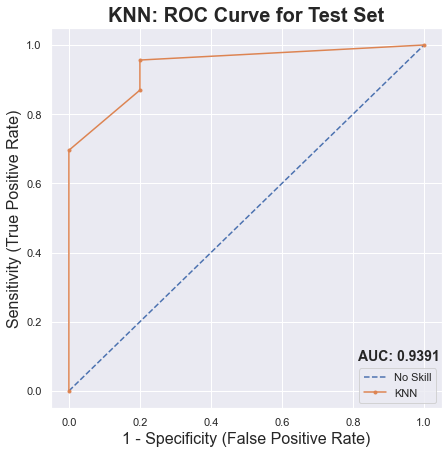

In [38]:
plot_roc_curve('KNN')

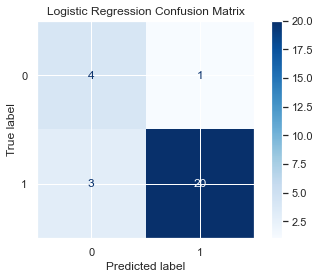

In [39]:
create_confusion_matrix('Logistic Regression', knn_model, X_test, y_test)

### Random Forest

#### Grid Search for Hyperparameters

In [40]:
rf_model = RandomForestClassifier(random_state = 42)
rf_grid_params = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

grid_search(rf_model, rf_grid_params, X_train, y_train)

{'max_depth': 3, 'n_estimators': 100}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.84166667 0.85       0.875      0.875             nan
 0.86666667 0.90833333 0.9        0.9               nan 0.91666667
 0.925      0.91666667 0.91666667        nan 0.91666667 0.925
 0.91666667 0.91666667]
  warnings.warn(


#### Model Performance

In [41]:
rf_model = RandomForestClassifier(max_depth = 4, n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [42]:
print_metrics(y_test, y_pred)

Sens Score: 0.8261
Spec Score: 0.8000
PPV Score: 0.9500
NPV Score: 0.5000
Acc Score: 0.8214
F1 Score: 0.8837


In [43]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.9652


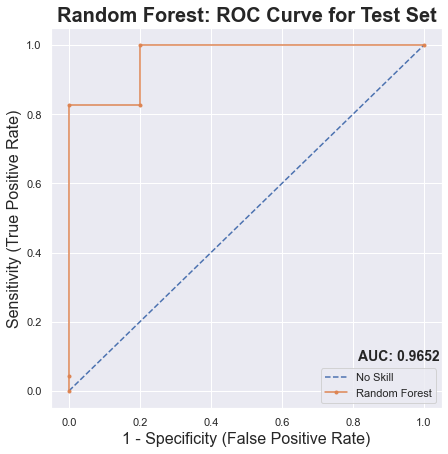

In [44]:
plot_roc_curve('Random Forest')

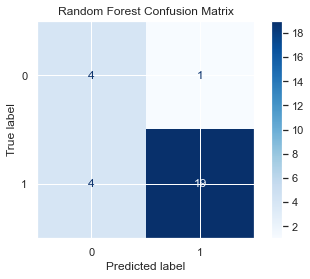

In [45]:
create_confusion_matrix('Random Forest', rf_model, X_test, y_test)

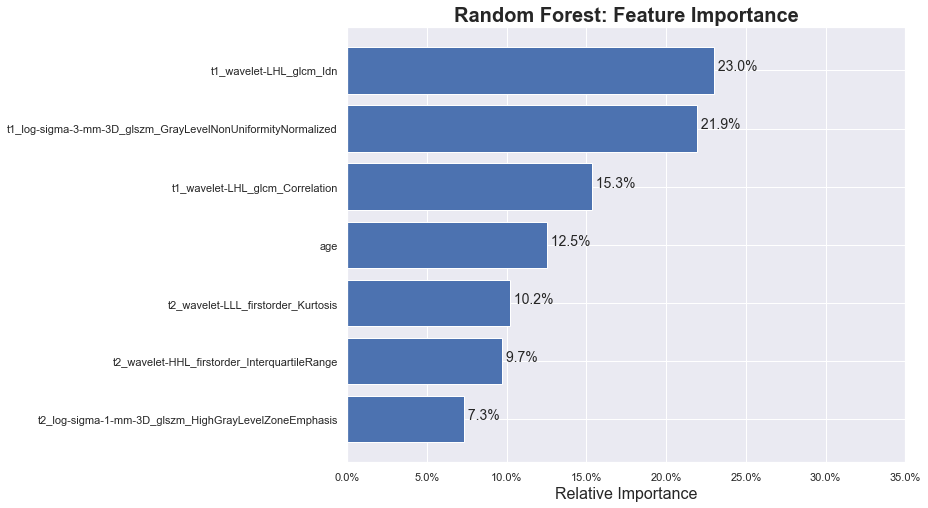

In [46]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Random Forest: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.35)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### XGBoost

#### Grid Search for Hyperparameters

In [47]:
xgb_model = XGBClassifier(random_state = 42)
xgb_grid_params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

grid_search(xgb_model, xgb_grid_params, X_train, y_train)

{'learning_rate': 0.1, 'max_depth': 3}


#### Model Performance

In [48]:
xgb_model = XGBClassifier(learning_rate = 0.5, max_depth = 6, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [49]:
print_metrics(y_test, y_pred)

Sens Score: 0.8261
Spec Score: 0.8000
PPV Score: 0.9500
NPV Score: 0.5000
Acc Score: 0.8214
F1 Score: 0.8837


In [50]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.9478


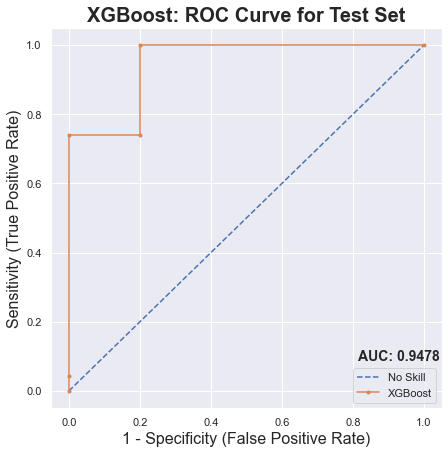

In [51]:
plot_roc_curve('XGBoost')

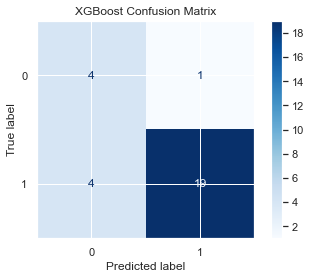

In [52]:
create_confusion_matrix('XGBoost', xgb_model, X_test, y_test)

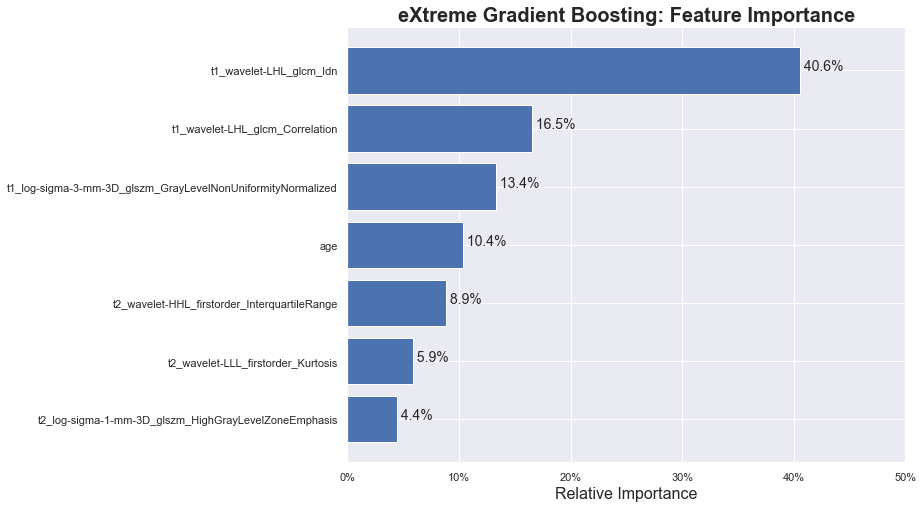

In [53]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('eXtreme Gradient Boosting: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.5)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### Neural Net

#### Grid Search for Hyperparameters

In [54]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
nn_grid_params = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search(nn_model, nn_grid_params, X_train, y_train)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


#### Model Performance

In [55]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [56]:
print_metrics(y_test, y_pred)

Sens Score: 0.9565
Spec Score: 0.8000
PPV Score: 0.9565
NPV Score: 0.8000
Acc Score: 0.9286
F1 Score: 0.9565


In [57]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print("AUC: " + str.format('{0:.4f}',auc))

AUC: 0.9478


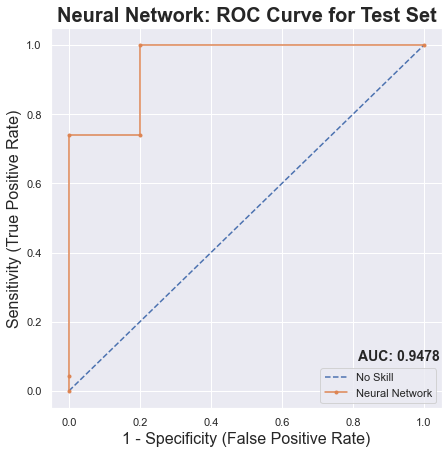

In [58]:
plot_roc_curve('Neural Network')

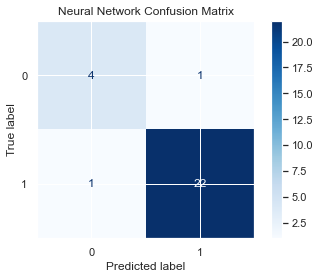

In [59]:
create_confusion_matrix('Neural Network', nn_model, X_test, y_test)